# Imports

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import model1
import data
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

# Data

## Configuration

In [8]:
height = 512
width = 384
classes = {"cardboard":(0, 403),
        "glass":(1, 501),
        "metal":(2, 410),
        "paper":(3, 594),
        "plastic":(4, 482),
        "trash":(5, 137)}
skin_tones = {0:(41, 23, 9),#darker
              1:(95, 51, 16),
              2:(127, 68, 34),
              3:(178, 102, 68),
              4:(115, 63, 23),
              5:(147, 95, 55),
              6:(173, 138, 96),
              7:(207, 150, 95),
              8:(187, 101, 54),
              9:(212, 158, 122),
              11:(242, 194, 128),
              12:(236, 192, 145),
              13:(249, 212, 160),
              14:(248, 217, 152),
              15:(253, 231, 173),
              16:(254, 227, 197)}#paler

## Collection

# Model 1

### data load without mask

In [9]:
collector = data.DataCollector(height, width, classes)
datasets = collector.collect('trashnet/dataset-resized', val_size=0.2, test_size=0.2)

Store in X and y


## Construction

In [12]:
unique_filename_model1 = "seqno4_model1"
model = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.001,
    bs = 64,
    rho = 0.9,
    gamma_step = 0.5,
    gamma = 0.9,
    num_active_layers = 5,
    if_replace = True,
    workers = 1,
    epochs = 25,
    mask = False,
    unique_filename = unique_filename_model1,
    model_type = 1,
    model_weights_ref_path = "ResNet34_Weights.pth"
    )

In [13]:
summary(model.model, input_size=(model.batch_size, 3, model.height, model.width))

/home/ss9295/.conda/envs/iw/lib/python3.10/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/home/ss9295/.conda/envs/iw/lib/python3.10/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [64, 6]                   --
├─Conv2d: 1-1                            [64, 64, 256, 192]        (9,408)
├─BatchNorm2d: 1-2                       [64, 64, 256, 192]        (128)
├─ReLU: 1-3                              [64, 64, 256, 192]        --
├─MaxPool2d: 1-4                         [64, 64, 128, 96]         --
├─Sequential: 1-5                        [64, 64, 128, 96]         --
│    └─BasicBlock: 2-1                   [64, 64, 128, 96]         --
│    │    └─Conv2d: 3-1                  [64, 64, 128, 96]         (36,864)
│    │    └─BatchNorm2d: 3-2             [64, 64, 128, 96]         (128)
│    │    └─ReLU: 3-3                    [64, 64, 128, 96]         --
│    │    └─Conv2d: 3-4                  [64, 64, 128, 96]         (36,864)
│    │    └─BatchNorm2d: 3-5             [64, 64, 128, 96]         (128)
│    │    └─ReLU: 3-6                    [64, 64, 128, 96] 

In [14]:
model.construct_data(datasets)

## Training

In [15]:
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model.train()

Epoch:   1 	 Training Loss: 1.66458 	 Training Accuracy: 0.32298 	 Validation Loss: 1.52536 	 Validation Accuracy: 0.41980
Epoch:   2 	 Training Loss: 1.36568 	 Training Accuracy: 0.45443 	 Validation Loss: 1.32764 	 Validation Accuracy: 0.50099
Epoch:   3 	 Training Loss: 1.20646 	 Training Accuracy: 0.56445 	 Validation Loss: 1.27951 	 Validation Accuracy: 0.51881
Epoch:   4 	 Training Loss: 1.08843 	 Training Accuracy: 0.61115 	 Validation Loss: 1.22756 	 Validation Accuracy: 0.53465
Epoch:   5 	 Training Loss: 0.98496 	 Training Accuracy: 0.67549 	 Validation Loss: 1.19324 	 Validation Accuracy: 0.54455
Epoch:   6 	 Training Loss: 0.88141 	 Training Accuracy: 0.71845 	 Validation Loss: 1.17511 	 Validation Accuracy: 0.56040
Epoch:   7 	 Training Loss: 0.80043 	 Training Accuracy: 0.76201 	 Validation Loss: 1.15691 	 Validation Accuracy: 0.56436
Epoch:   8 	 Training Loss: 0.72937 	 Training Accuracy: 0.79954 	 Validation Loss: 1.15604 	 Validation Accuracy: 0.57426
Epoch:   9 	 Tra

In [16]:
test_loss, test_accuracy = model.test()
test_loss, test_accuracy

(1.131502389907837, tensor(0.5968))

# Model2 with mask

## data collection with mask

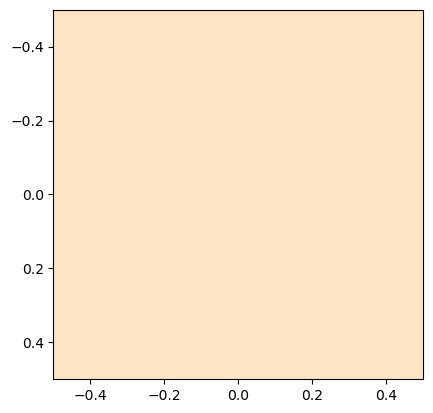

In [33]:
plt.imshow(np.expand_dims(np.array(skin_tones[16]),axis = (0,1)))
plt.show()

In [17]:
collector2 = data.DataCollector(height, width, classes,
                               mask_opts = {"mask_size":10,"skintone_label":15,
                               })
datasets2 = collector2.collect('trashnet/dataset-resized', val_size=0.2, test_size=0.2)

Store in X and y


In [20]:
model2 = model1.Model(
    height=height,
    width=width,
    num_classes=len(classes),
    lr=0.001,
    bs = 64,
    rho = 0.9,
    gamma_step = 0.5,
    gamma = 0.9,
    num_active_layers = 5,
    if_replace = True,
    workers = 1,
    epochs = 25,
    mask = True,
    unique_filename = "seqno5_model2",
    model_type = 2,
    model_weights_ref_path = f'models/{unique_filename_model1}/model.pth'
    )

In [21]:
model2.construct_data(datasets2)

In [22]:
_, avg_training_loss, avg_training_accuracy, validation_loss, validation_accuracy = model2.train()

Epoch:   1 	 Training Loss: 0.98364 	 Training Accuracy: 0.63429 	 Validation Loss: 1.19058 	 Validation Accuracy: 0.54653
Epoch:   2 	 Training Loss: 0.64310 	 Training Accuracy: 0.79421 	 Validation Loss: 1.14307 	 Validation Accuracy: 0.56436
Epoch:   3 	 Training Loss: 0.44638 	 Training Accuracy: 0.88855 	 Validation Loss: 1.13451 	 Validation Accuracy: 0.57822
Epoch:   4 	 Training Loss: 0.31374 	 Training Accuracy: 0.94614 	 Validation Loss: 1.13639 	 Validation Accuracy: 0.60000
Epoch:   5 	 Training Loss: 0.23369 	 Training Accuracy: 0.97508 	 Validation Loss: 1.14822 	 Validation Accuracy: 0.59010
Epoch:   6 	 Training Loss: 0.17641 	 Training Accuracy: 0.98603 	 Validation Loss: 1.15478 	 Validation Accuracy: 0.59802
Epoch:   7 	 Training Loss: 0.13240 	 Training Accuracy: 0.99094 	 Validation Loss: 1.17892 	 Validation Accuracy: 0.58812
Epoch:   8 	 Training Loss: 0.11565 	 Training Accuracy: 0.99450 	 Validation Loss: 1.19440 	 Validation Accuracy: 0.59406
Epoch:   9 	 Tra

In [23]:
test_loss, test_accuracy = model2.test()
test_loss, test_accuracy

(1.2986149787902832, tensor(0.5751))